## Run Clay

This notebook shows how to run Clay model wall-to-wall, from downloading imagery
to training a tiny, fine-tuned head. This will include the following steps:

1. Set a location and date range of interest
2. Download Sentinel-2 imagery for this specification
3. Load the model checkpoint
4. Prepare data into a format for the model
5. Run the model on the imagery
6. Analyse the model embeddings output using PCA
7. Train a Support Vector Machine fine-tuning head

In [1]:
# Add the repo root to the sys path for the model import below
import sys

sys.path.append("../..")

In [2]:
import math

import geopandas as gpd
import numpy as np
import pandas as pd
import pystac_client
import stackstac
import torch
import yaml
from box import Box
from matplotlib import pyplot as plt
from rasterio.enums import Resampling
from shapely import Point
from sklearn import decomposition, svm
from torchvision.transforms import v2

from claymodel.module import ClayMAEModule

/opt/conda/envs/claymodel/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/claymodel/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### Specify location and date of interest
In this example we will use a location in Portugal where a forest fire happened. We will run the model over the time period of the fire and analyse the model embeddings.

In [3]:
# Point over Monchique Portugal
lat, lon = 37.30939, -8.57207

# Dates of a large forest fire
start = "2018-07-01"
end = "2018-09-01"

### Get data from STAC catalog

Based on the location and date we can obtain a stack of imagery using stackstac. Let's start with finding the STAC items we want to analyse.

In [4]:
STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    bbox=(lon - 1e-5, lat - 1e-5, lon + 1e-5, lat + 1e-5),
    max_items=100,
    query={"eo:cloud_cover": {"lt": 80}},
)

all_items = search.get_all_items()

# Reduce to one per date (there might be some duplicates
# based on the location)
items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

/opt/conda/envs/claymodel/lib/python3.11/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Found 12 items


### Create a bounding box around the point of interest

This is needed in the projection of the data so that we can generate image chips of the right size.

In [5]:
# Extract coordinate system from first item
epsg = items[0].properties["proj:epsg"]

# Convert point of interest into the image projection
# (assumes all images are in the same projection)
poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(lon, lat)],
).to_crs(epsg)

coords = poidf.iloc[0].geometry.coords[0]

# Create bounds in projection
size = 256
gsd = 10
bounds = (
    coords[0] - (size * gsd) // 2,
    coords[1] - (size * gsd) // 2,
    coords[0] + (size * gsd) // 2,
    coords[1] + (size * gsd) // 2,
)

### Retrieve the imagery data.

In [6]:
# Retrieve the pixel values, for the bounding box in
# the target projection. In this example we use only
# the RGB and NIR bands.
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    dtype="float32",
    rescale=False,
    fill_value=0,
    assets=["blue", "green", "red", "nir"],
    resampling=Resampling.nearest,
)

print(stack)

stack = stack.compute()

<xarray.DataArray 'stackstac-92a55b370e10e42a681db57c11d009f2' (time: 12,
                                                                band: 4,
                                                                y: 256, x: 256)> Size: 13MB
dask.array<fetch_raster_window, shape=(12, 4, 256, 256), dtype=float32, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 96B 2018-0...
    id                                       (time) <U24 1kB 'S2B_29SNB_20180...
  * band                                     (band) <U5 80B 'blue' ... 'nir'
  * x                                        (x) float64 2kB 5.366e+05 ... 5....
  * y                                        (y) float64 2kB 4.131e+06 ... 4....
    s2:generation_time                       (time) <U27 1kB '2018-07-04T17:3...
    ...                                       ...
    gsd                                      int64 8B 10
    proj:shape            

/opt/conda/envs/claymodel/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


### Let's have a look at the imagery we just downloaded

The imagery will contain 7 dates before the fire, of which two are pretty cloudy images. There are also 5 images after the forest fire.

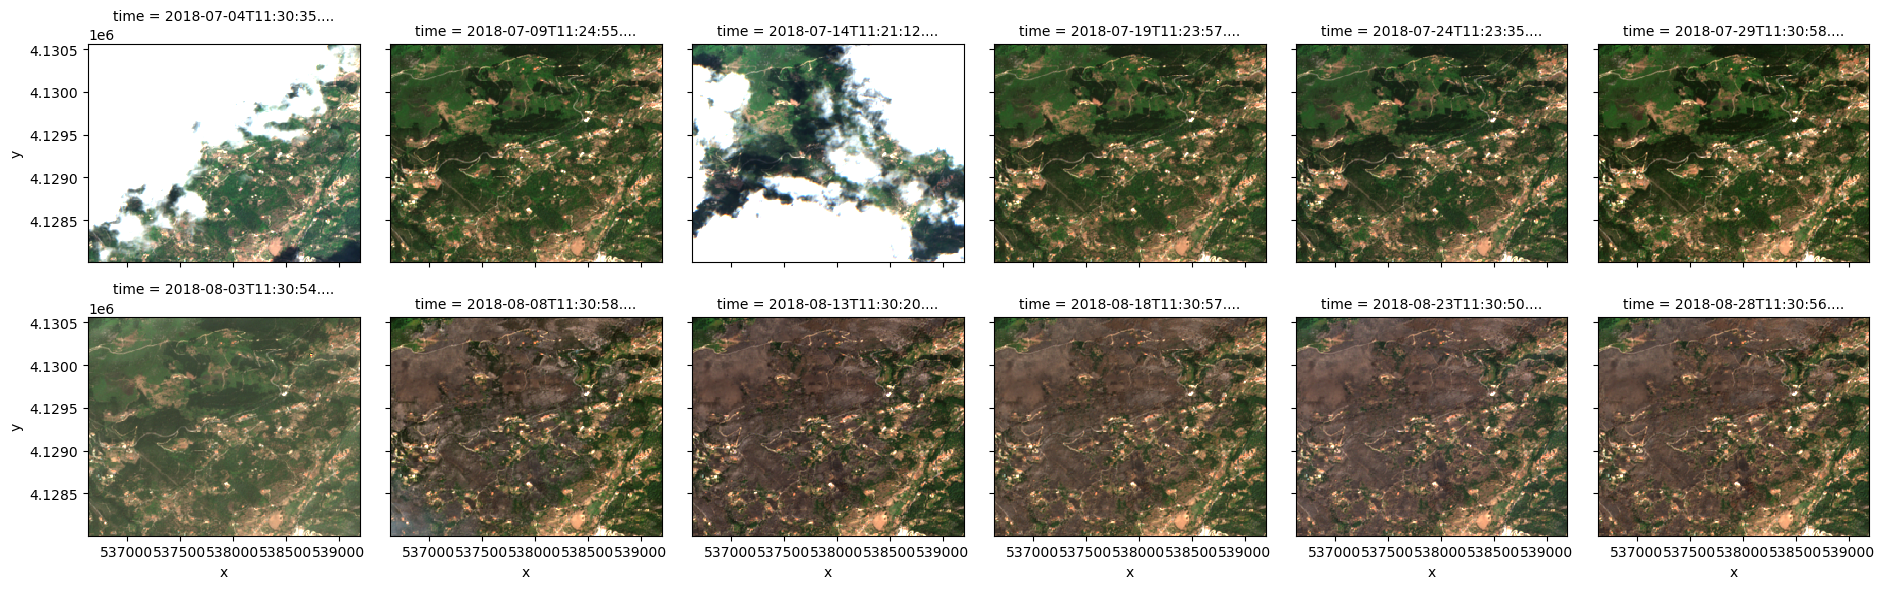

In [7]:
stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

![Minicube visualization](https://github.com/Clay-foundation/model/assets/901647/c6e924e5-6ba1-4924-b99a-df8b90731a5f)

### Load the model

We now have the data to analyse, let's load the model.

In [ ]:
!wget -q https://huggingface.co/made-with-clay/Clay/resolve/main/v1.5/clay-v1.5.ckpt

In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "clay-v1.5.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt,
    model_size="large",
    metadata_path="../../configs/metadata.yaml",
    dolls=[16, 32, 64, 128, 256, 768, 1024],
    doll_weights=[1, 1, 1, 1, 1, 1, 1],
    mask_ratio=0.0,
    shuffle=False,
)
model.eval()

model = model.to(device)

/opt/conda/envs/claymodel/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.1.4


### Prepare band metadata for passing it to the model

This is the most technical part so far. We will take the information in the stack of imagery and convert it into the format that the model requires. This includes converting the lat/lon and the date of the imagery into normalized values.

The Clay model will accept any band combination in any order, from different platforms. But for this the model needs to know the wavelength of each band that is passed to it, and normalization parameters for each band as well. It will use that to normalize the data and to interpret each band based on its central wavelength.

For Sentinel-2 we can use a metadata file of the model to extract those values. But this could also be something custom for a different platform.

In [21]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
metadata = Box(yaml.safe_load(open("../../configs/metadata.yaml")))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in stack.band:
    mean.append(metadata[platform].bands.mean[str(band.values)])
    std.append(metadata[platform].bands.std[str(band.values)])
    waves.append(metadata[platform].bands.wavelength[str(band.values)])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

### Convert the band pixel data into the format for the model

We will take the information in the stack of imagery and convert it into the format that the model requires. This includes converting the lat/lon and the date of the imagery into normalized values.

In [22]:
# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


datetimes = stack.time.values.astype("datetime64[s]").tolist()
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
pixels = torch.from_numpy(stack.data.astype(np.float32))
pixels = transform(pixels)

### Combine the metadata and the transformed pixels

Now we can combine all these inputs into a dictionary that combines everything.

In [23]:
# Prepare additional information
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
    ),
    "pixels": pixels.to(device),
    "gsd": torch.tensor(stack.gsd.values, device=device),
    "waves": torch.tensor(waves, device=device),
}

### Run the model

Pass the datacube we prepared to the model to create embeddings. This will create one embedding vector for each of the images we downloaded.

In [24]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

### Analyse the embeddings

A simple analysis of the embeddings is to reduce each one of them into a single number using Principal Component Analysis. For this we will fit a PCA on the 12 embeddings we have and do the dimensionality reduction for them. We will se a separation into three groups, the previous images, the cloudy images, and the images after the fire, they all fall into a different range of the PCA space.

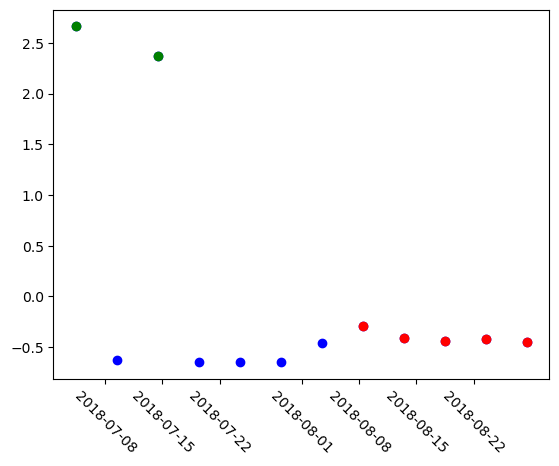

In [25]:
# Run PCA
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings)

plt.xticks(rotation=-45)

# Plot all points in blue first
plt.scatter(stack.time, pca_result, color="blue")

# Re-plot cloudy images in green
plt.scatter(stack.time[0], pca_result[0], color="green")
plt.scatter(stack.time[2], pca_result[2], color="green")

# Color all images after fire in red
plt.scatter(stack.time[-5:], pca_result[-5:], color="red")

### And finally, some fine-tuning

We are going to train a classifier head on the embeddings and use it to detect fires.

In [26]:
# Label the images we downloaded
# 0 = Cloud
# 1 = Forest
# 2 = Fire
labels = np.array([0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2])

# Split into fit and test manually, ensuring we have all 3 classes in both sets
fit = [0, 1, 3, 4, 7, 8, 9]
test = [2, 5, 6, 10, 11]

# Train a Support Vector Machine model
clf = svm.SVC()
clf.fit(embeddings[fit] + 100, labels[fit])

# Predict classes on test set
prediction = clf.predict(embeddings[test] + 100)

# Perfect match for SVM
match = np.sum(labels[test] == prediction)
print(f"Matched {match} out of {len(test)} correctly")

Matched 4 out of 5 correctly
